In [2]:
import cv2
import numpy as np
import math
from random import randint

In [3]:
"""
new_width, new_height = 600 , 600
im = cv2.imread("f1.jpg", cv2.IMREAD_GRAYSCALE)
resized_image = cv2.resize(im, (new_width, new_height))
cv2.imshow('Circles',resized_image )
cv2.waitKey(0)
cv2.destroyAllWindows()
"""

'\nnew_width, new_height = 600 , 600\nim = cv2.imread("f1.jpg", cv2.IMREAD_GRAYSCALE)\nresized_image = cv2.resize(im, (new_width, new_height))\ncv2.imshow(\'Circles\',resized_image )\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n'

In [4]:
def crop_to_circle(image):
    """Crop the input image to a circular shape."""
    height, width = image.shape
    center = (width // 2, height // 2)
    radius = min(center)
    
    # Create a circular mask
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)
    
    # Apply the mask to the image
    cropped = cv2.bitwise_and(image, image, mask=mask)
    return cropped, center, radius
def generate_nail_positions(center, radius, num_nails):
    """Generate evenly spaced nail positions around the circle."""
    nails = []
    for i in range(num_nails):
        angle = 2 * math.pi * i / num_nails
        x = int(center[0] + radius * math.cos(angle))
        y = int(center[1] + radius * math.sin(angle))
        nails.append((x, y))
    return nails


In [5]:
def bresenham_line(x0, y0, x1, y1):
    """Return a list of points along a straight line between (x0, y0) and (x1, y1)."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    return points


In [14]:
image = cv2.imread('m.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (1000, 1000))
#_, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
image,c,r = crop_to_circle(image)
nail = generate_nail_positions(c,r,200)
print(nail)
for i in nail:
    cv2.circle(image, i , 2, (0, 0, 0), 2)
cv2.imshow('String Art', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[(1000, 500), (999, 515), (999, 531), (997, 547), (996, 562), (993, 578), (991, 593), (987, 609), (984, 624), (980, 639), (975, 654), (970, 669), (964, 684), (958, 698), (952, 712), (945, 726), (938, 740), (930, 754), (922, 767), (913, 781), (904, 793), (895, 806), (885, 818), (875, 830), (864, 842), (853, 853), (842, 864), (830, 875), (818, 885), (806, 895), (793, 904), (781, 913), (767, 922), (754, 930), (740, 938), (726, 945), (712, 952), (698, 958), (684, 964), (669, 970), (654, 975), (639, 980), (624, 984), (609, 987), (593, 991), (578, 993), (562, 996), (547, 997), (531, 999), (515, 999), (500, 1000), (484, 999), (468, 999), (452, 997), (437, 996), (421, 993), (406, 991), (390, 987), (375, 984), (360, 980), (345, 975), (330, 970), (315, 964), (301, 958), (287, 952), (273, 945), (259, 938), (245, 930), (232, 922), (218, 913), (206, 904), (193, 895), (181, 885), (169, 875), (157, 864), (146, 853), (135, 842), (124, 830), (114, 818), (104, 806), (95, 793), (86, 781), (77, 767), (69,

In [ ]:
def calculate_integral(image, nail1, nail2):
    """Calculate the sum of pixel values along the line between two nails."""
    line_points = bresenham_line(nail1[0], nail1[1], nail2[0], nail2[1])
    total = 0
    height, width = image.shape
    for x, y in line_points:
        if (0 <= x < width) and (0 <= y < height):
            total += image[y,x]
    return total , len(line_points)

def string_art_generator(image, num_nails=200, max_iterations=1000):
    """Generate a string art sequence from the input image."""
    # Crop image to circle and get center/radius
    cropped_image, center, radius = crop_to_circle(image)
    # Generate nail positions
    nail_positions = generate_nail_positions(center, radius, num_nails)
    # Start at a random nail
    current_nail_idx = randint(0, num_nails - 1)
    sequence = [current_nail_idx]
    visited_pairs = set()
    
    # Main loop
    for _ in range(max_iterations - 1):
        current_nail = nail_positions[current_nail_idx]
        min_integral = 0.0
        next_nail_idx = -1
        
        # Evaluate all possible next nails
        for i, next_nail in enumerate(nail_positions):
            if (i == current_nail_idx):# or ((current_nail_idx, i) in visited_pairs):
                continue
            integral,n = calculate_integral(cropped_image, current_nail, next_nail)
            if integral/n > min_integral:  # Lower integral means darker path
                min_integral = integral/n
                next_nail_idx = i
        
        # If no valid next nail is found, break
        if next_nail_idx == -1:
            print("broken")
            break
        
        # Move to the next nail
        visited_pairs.add((current_nail_idx, next_nail_idx))
        cv2.line(cropped_image, nail_positions[current_nail_idx], nail_positions[next_nail_idx], (63,63,63), 1)
        current_nail_idx = next_nail_idx
        sequence.append(current_nail_idx)
        
    return nail_positions, sequence

def visualize_string_art(image, nail_positions, sequence):
    """Visualize the string art on a blank canvas."""
    canvas = np.ones_like(image) * 255  # White background
    for i in range(len(sequence) - 1):
        nail1 = nail_positions[sequence[i]]
        nail2 = nail_positions[sequence[i + 1]]
        cv2.line(canvas, nail1, nail2, (0,0,0), 1)  # Draw black lines
    return canvas

# Example usage
if __name__ == "__main__":
    # Load and preprocess the image
    image = cv2.imread('m.jpg', cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (1000, 1000))
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

    cv2.imshow('String Art', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    if image is None:
        print("Error: Could not load image.")
    else:
        # Generate string art
        nail_positions, sequence = string_art_generator(image, num_nails= 400, max_iterations= 1000)
        
        # Visualize the result
        result = visualize_string_art(image, nail_positions, sequence)
        
        # Save or display the result
        cv2.imwrite('string_art_output.jpg', result)
        cv2.imshow('String Art', result)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

(array([365., 305.,  17., 286., 269., 154.,  50., 296.,  29., 229.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

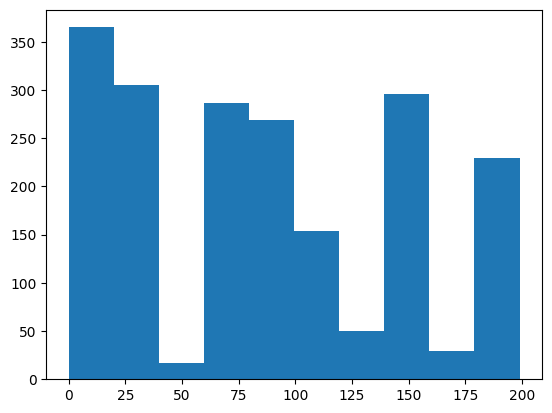

In [8]:
import matplotlib.pyplot as plt
plt.hist(sequence)

In [9]:
# https://github.com/grvlbit/stringart